# ecallistolib Plotting Tutorial

This notebook demonstrates all the plotting capabilities of the ecallistolib library, including:

- **Raw spectrum plotting** - View unprocessed data
- **Customizable plot parameters** - Control colormaps, clipping values, figure size, and more
- **Background subtraction** - Visualize data before clipping
- **Time axis conversion** - Switch between seconds and UT format
- **Light curve plotting** - Plot intensity vs time at a specific frequency

## Setup

In [21]:
import ecallistolib as ecl
import matplotlib.pyplot as plt
import numpy as np

# For inline plots
%matplotlib inline

## 1. Load Sample Data

First, let's load a sample FITS file. Make sure you have a sample file in the `data/` directory.

In [22]:
# Load the sample FITS file
ds = ecl.read_fits("/Users/saan/Desktop/ecallistolib/data/Arecibo-Observatory_20220302_174500_62.fit.gz")

print(f"Data shape: {ds.shape}")
print(f"Frequency range: {ds.freqs_mhz.min():.1f} - {ds.freqs_mhz.max():.1f} MHz")
print(f"Time range: {ds.time_s.min():.1f} - {ds.time_s.max():.1f} seconds")
print(f"Metadata: {ds.meta}")

Data shape: (200, 3600)
Frequency range: 15.0 - 86.6 MHz
Time range: 0.0 - 899.8 seconds
Metadata: {'ut_start_sec': 63900.896, 'station': 'Arecibo-Observatory', 'date': '20220302', 'time': '174500', 'focus': '62'}


## 2. Plot Raw Spectrum

Use `plot_raw_spectrum()` to visualize the data without any processing.

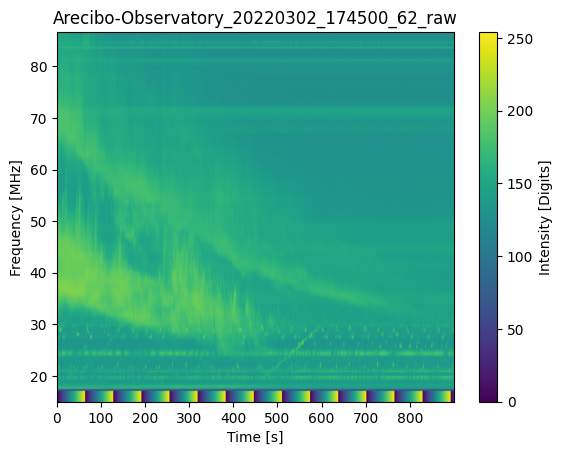

In [40]:
# Basic raw spectrum plot
fig, ax, im = ecl.plot_raw_spectrum(ds)
plt.show()

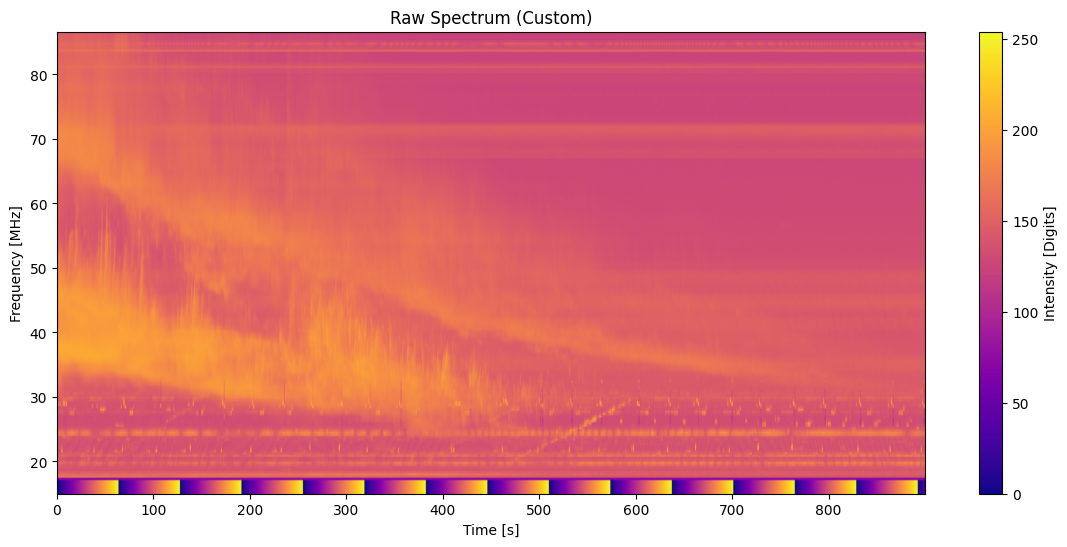

In [24]:
# Customized raw spectrum with figure size and colormap
fig, ax, im = ecl.plot_raw_spectrum(
    ds,
    title="Raw Spectrum (Custom)",
    cmap="plasma",
    figsize=(14, 6),
)
plt.show()

## 3. Background Subtraction (Before Clipping)

The `background_subtract()` function removes the mean per frequency channel without applying clipping. This helps visualize deviations from the baseline.

In [25]:
# Apply background subtraction only (no clipping)
ds_bg = ecl.background_subtract(ds)

# Verify each frequency channel now has zero mean
print(f"Mean per channel (should be ~0): {ds_bg.data.mean(axis=1)[:5]}")
print(f"Processing metadata: {ds_bg.meta.get('processing')}")

Mean per channel (should be ~0): [-6.56857285e-15 -3.03164901e-15 -4.04219867e-15 -7.57912251e-15
 -1.16213212e-14]
Processing metadata: {'method': 'background_subtract'}


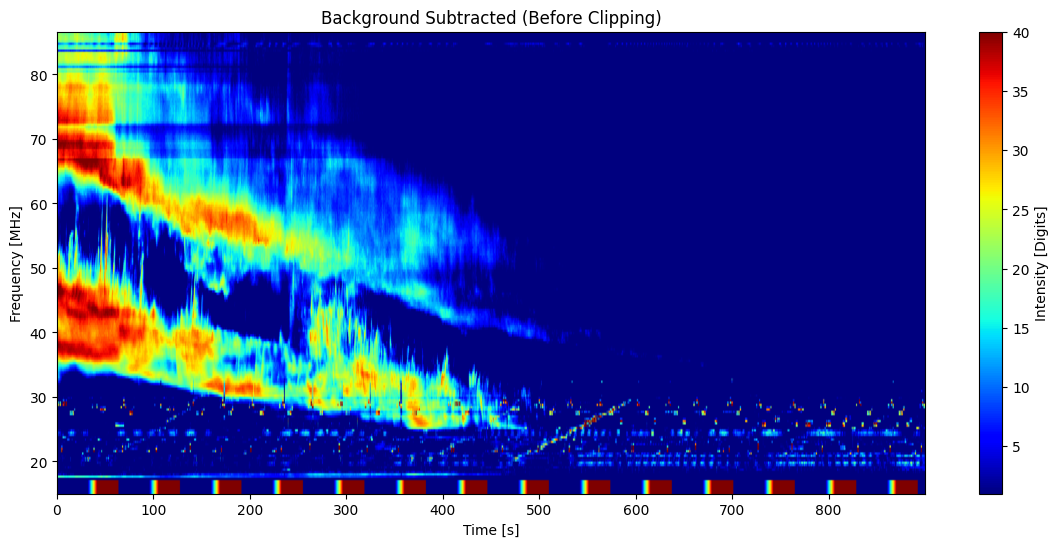

In [26]:
# Use the convenience function to plot background subtracted data
fig, ax, im = ecl.plot_background_subtracted(
    ds,
    title="Background Subtracted (Before Clipping)",
    clip_low=1,
    clip_high=40,
    cmap="jet",  # Diverging colormap shows +/- deviations
    figsize=(14, 6),
)
plt.show()

## 4. Noise Reduction with Custom Clipping

Apply the full noise reduction pipeline (background subtraction + clipping + scaling).

In [27]:
# Apply noise reduction with custom clipping values
ds_reduced = ecl.noise_reduce_mean_clip(
    ds,
    clip_low=-5.0,
    clip_high=20.0,
    scale=None  # Disable scaling for this example
)

print(f"Processing metadata: {ds_reduced.meta.get('noise_reduction')}")

Processing metadata: {'method': 'mean_subtract_clip', 'clip_low': -5.0, 'clip_high': 20.0, 'scale': None}


## 5. Customizable Plot Parameters

`plot_dynamic_spectrum()` now supports:
- `clip_low` / `clip_high` - Colormap clipping values
- `figsize` - Figure size in inches
- `cmap` - Any matplotlib colormap
- `**imshow_kwargs` - Any additional matplotlib imshow parameters

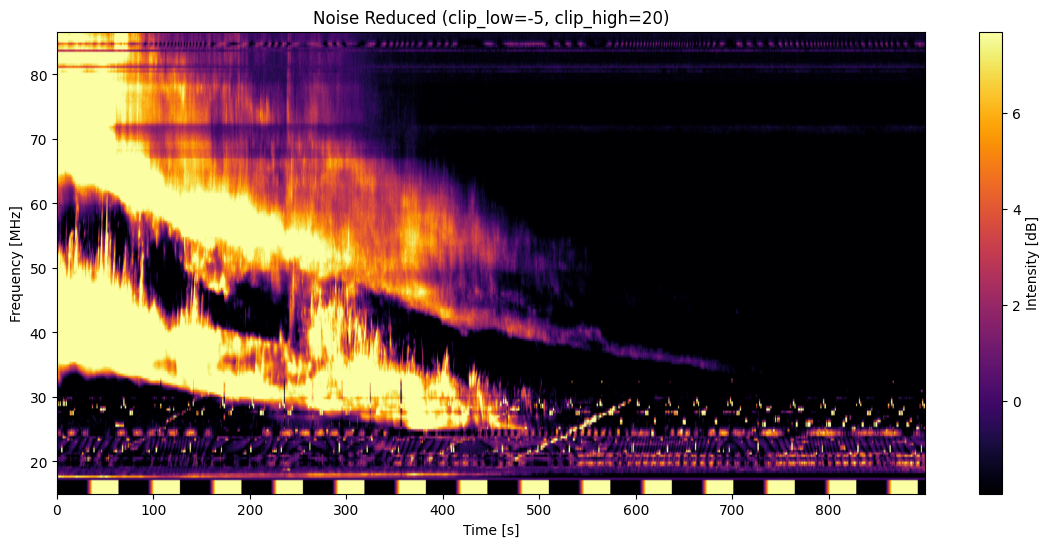

In [28]:
# Plot with custom clipping values and colormap
fig, ax, im = ecl.plot_dynamic_spectrum(
    ds_reduced,
    title="Noise Reduced (clip_low=-5, clip_high=20)",
    clip_low=-5,
    clip_high=20,
    cmap="inferno",
    figsize=(14, 6),
    intensity_units = "dB"
)
plt.show()

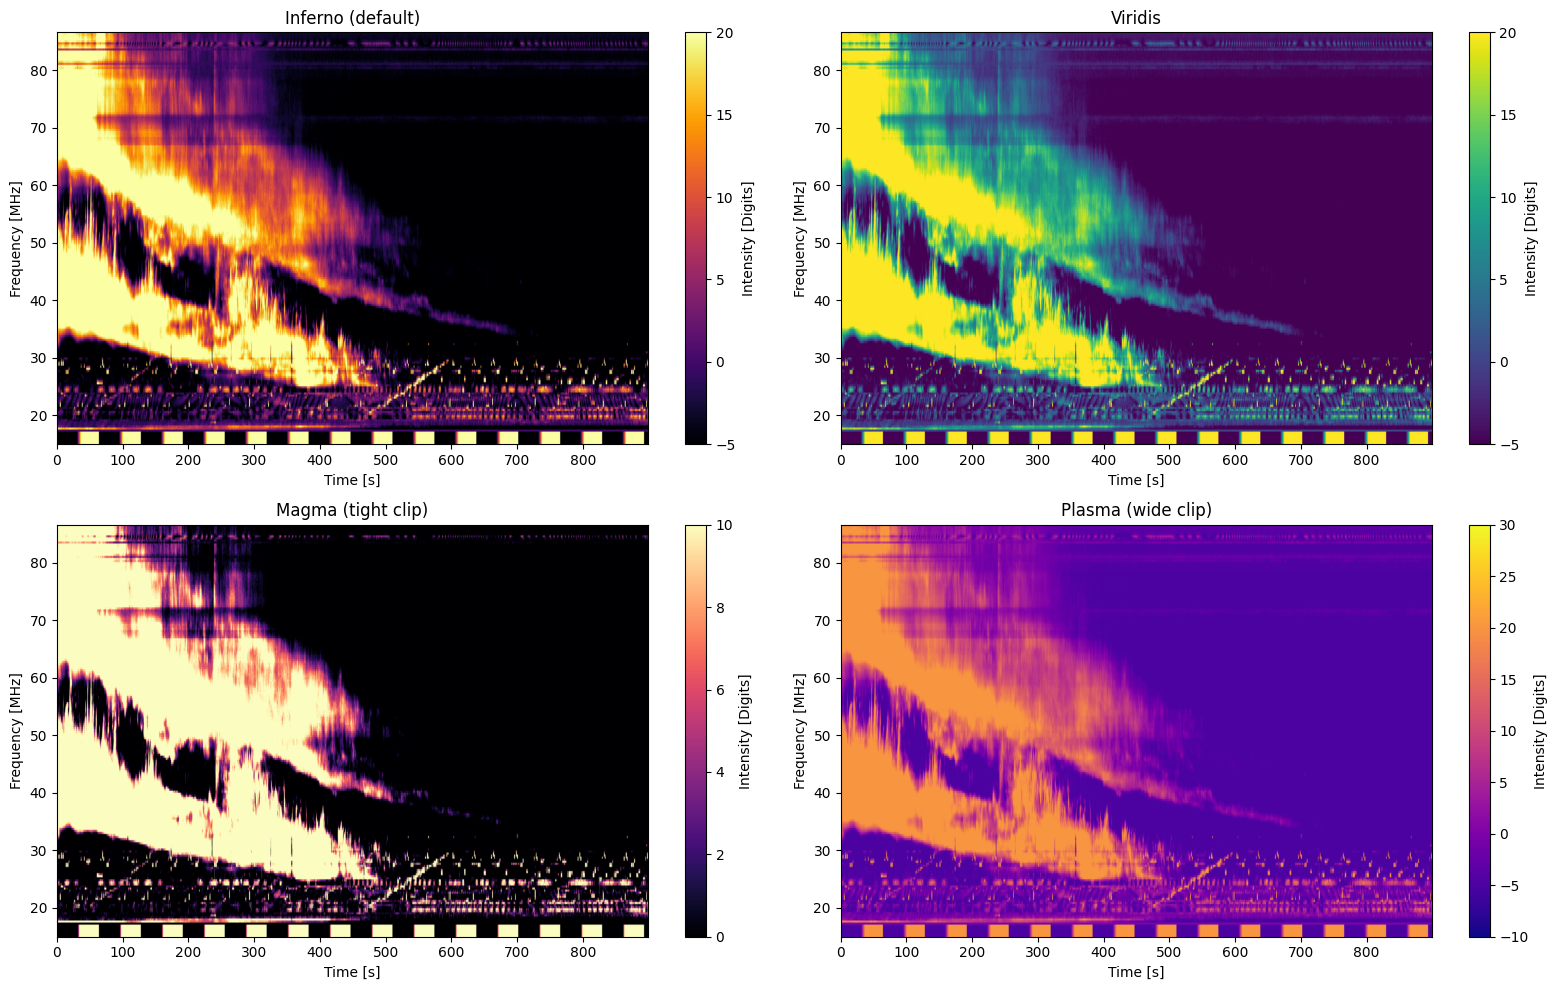

In [29]:
# Try different colormaps and clipping values
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

configs = [
    {"title": "Inferno (default)", "cmap": "inferno", "vmin": -5, "vmax": 20},
    {"title": "Viridis", "cmap": "viridis", "vmin": -5, "vmax": 20},
    {"title": "Magma (tight clip)", "cmap": "magma", "vmin": 0, "vmax": 10},
    {"title": "Plasma (wide clip)", "cmap": "plasma", "vmin": -10, "vmax": 30},
]

for ax, cfg in zip(axes.flat, configs):
    ecl.plot_dynamic_spectrum(
        ds_reduced,
        ax=ax,
        title=cfg["title"],
        cmap=cfg["cmap"],
        clip_low=cfg["vmin"],
        clip_high=cfg["vmax"],
    )

plt.tight_layout()
plt.show()

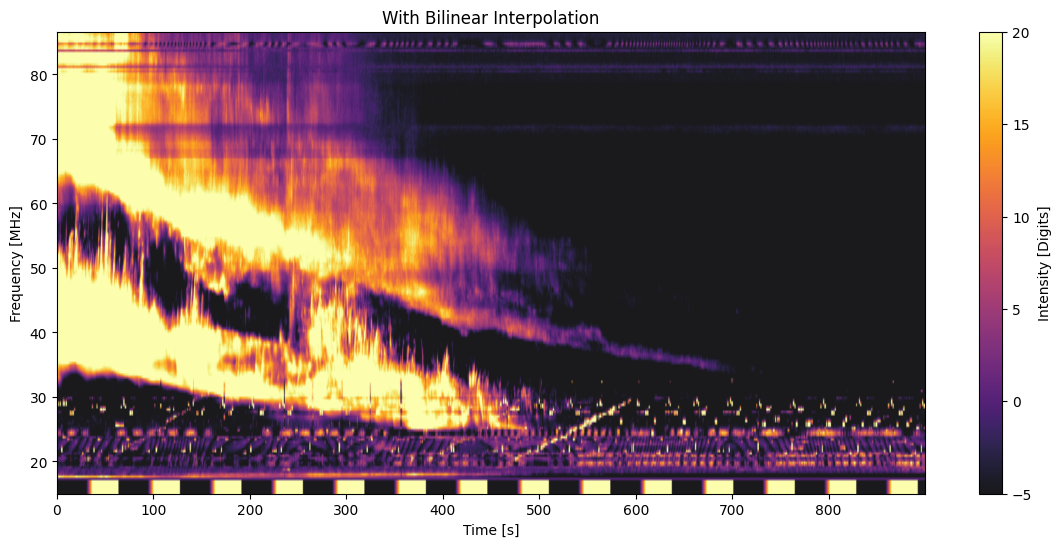

In [30]:
# Pass additional matplotlib imshow parameters
fig, ax, im = ecl.plot_dynamic_spectrum(
    ds_reduced,
    title="With Bilinear Interpolation",
    clip_low=-5,
    clip_high=20,
    cmap="inferno",
    figsize=(14, 6),
    interpolation="bilinear",  # Smooth interpolation
    alpha=0.9,  # Slight transparency
)
plt.show()

## 6. Time Axis Formats

Display time in seconds or UT (Universal Time) format using the `time_format` parameter.

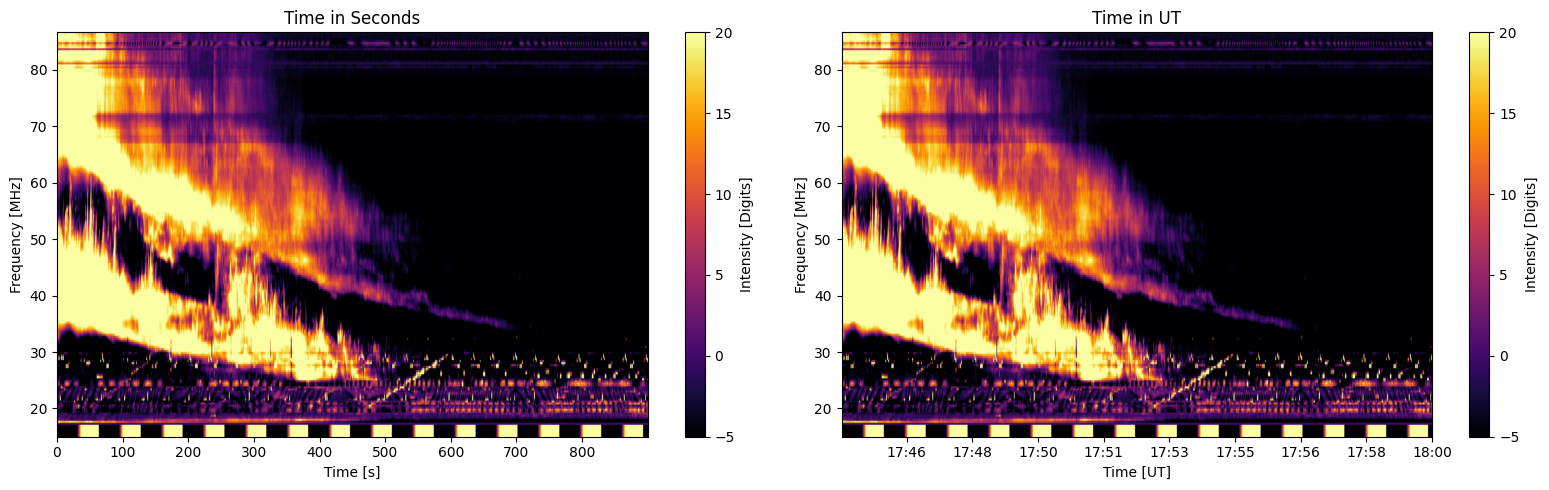

In [31]:
# Compare time formats side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Time in seconds (default)
ecl.plot_dynamic_spectrum(
    ds_reduced,
    ax=axes[0],
    title="Time in Seconds",
    time_format="seconds",
    clip_low=-5,
    clip_high=20,
)

# Time in UT format
ecl.plot_dynamic_spectrum(
    ds_reduced,
    ax=axes[1],
    title="Time in UT",
    time_format="ut",
    clip_low=-5,
    clip_high=20,
)

plt.tight_layout()
plt.show()

## 7. TimeAxisConverter

The `TimeAxisConverter` class provides programmatic conversion between elapsed seconds and UT time.

In [32]:
# Create a converter from the spectrum's metadata
converter = ecl.TimeAxisConverter.from_dynamic_spectrum(ds)

print(f"UT start time: {converter.ut_start_sec} seconds since midnight")
print(f"UT start time: {converter.seconds_to_ut(0)}")

UT start time: 63900.896 seconds since midnight
UT start time: 17:45


In [33]:
# Convert seconds to UT
test_times = [0, 60, 100, 300, 600]

print("Seconds → UT conversion:")
for t in test_times:
    ut = converter.seconds_to_ut(t)
    print(f"  {t:5d} seconds → {ut}")

Seconds → UT conversion:
      0 seconds → 17:45
     60 seconds → 17:46
    100 seconds → 17:46
    300 seconds → 17:50
    600 seconds → 17:55


In [34]:
# Convert UT back to seconds
test_ut_times = ["12:00:00", "12:01:00", "12:05:00", "12:10:00"]

print("UT → Seconds conversion:")
for ut in test_ut_times:
    seconds = converter.ut_to_seconds(ut)
    print(f"  {ut} → {seconds:.1f} seconds")

UT → Seconds conversion:
  12:00:00 → -20700.9 seconds
  12:01:00 → -20640.9 seconds
  12:05:00 → -20400.9 seconds
  12:10:00 → -20100.9 seconds


In [35]:
# Create a converter manually
manual_converter = ecl.TimeAxisConverter(ut_start_sec=43200.0)  # 12:00:00

print(f"Manual converter start: {manual_converter.seconds_to_ut(0)}")
print(f"After 1 hour: {manual_converter.seconds_to_ut(3600)}")

Manual converter start: 12:00
After 1 hour: 13:00


## 8. Light Curve Plotting

Plot intensity vs time at a specific frequency using `plot_light_curve()`. This is useful for analyzing temporal variations at a particular frequency.

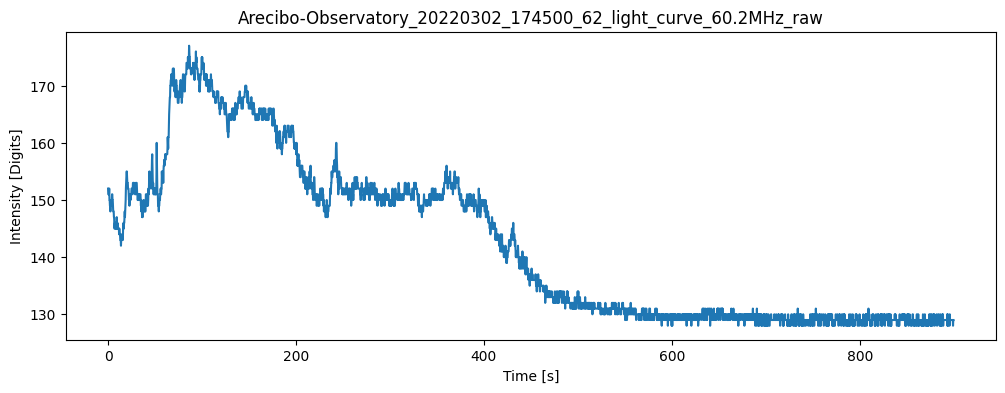

In [36]:
# Plot a raw light curve at 60 MHz
fig, ax, line = ecl.plot_light_curve(
    ds,
    frequency_mhz=60,
    process="raw",
    figsize=(12, 4),
)
plt.show()

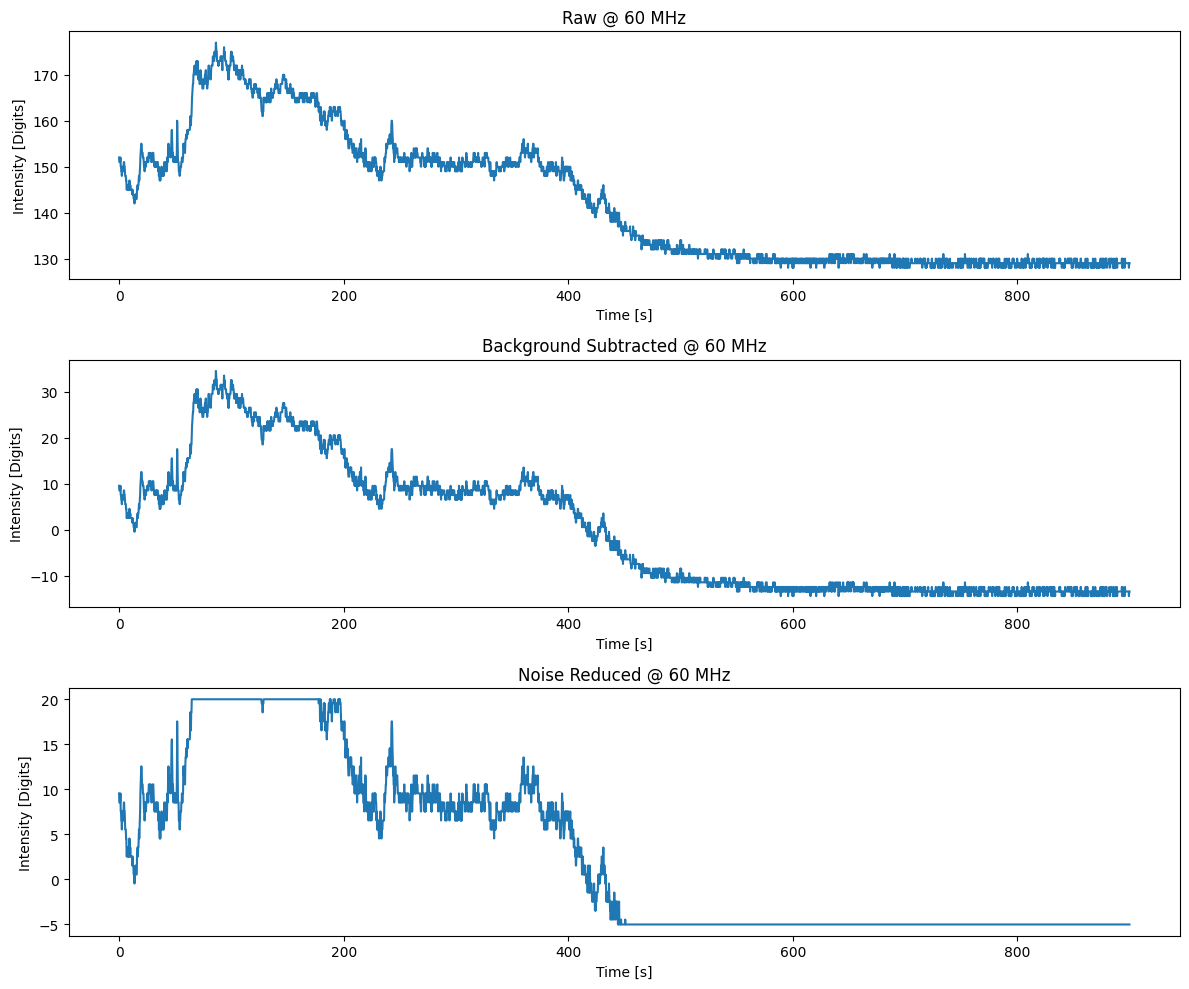

In [37]:
# Compare all three processing modes
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Raw data
ecl.plot_light_curve(
    ds, frequency_mhz=60, process="raw",
    ax=axes[0], title="Raw @ 60 MHz",
)

# Background subtracted
ecl.plot_light_curve(
    ds, frequency_mhz=60, process="background_subtracted",
    ax=axes[1], title="Background Subtracted @ 60 MHz",
)

# Noise reduced (must provide clip values)
ecl.plot_light_curve(
    ds, frequency_mhz=60, process="noise_reduced",
    ax=axes[2], title="Noise Reduced @ 60 MHz",
    clip_low=-5, clip_high=20,
)

plt.tight_layout()
plt.show()

In [38]:
# Handle out-of-range frequency errors
try:
    ecl.plot_light_curve(ds, frequency_mhz=500)  # Out of range
except ecl.FrequencyOutOfRangeError as e:
    print(f"Error: {e}")

Error: Requested frequency 500 MHz is outside the spectrum's frequency range [15.00, 86.62] MHz.


## 9. Complete Workflow

Putting it all together - a complete analysis workflow.

Loaded: Arecibo-Observatory observation from 20220302


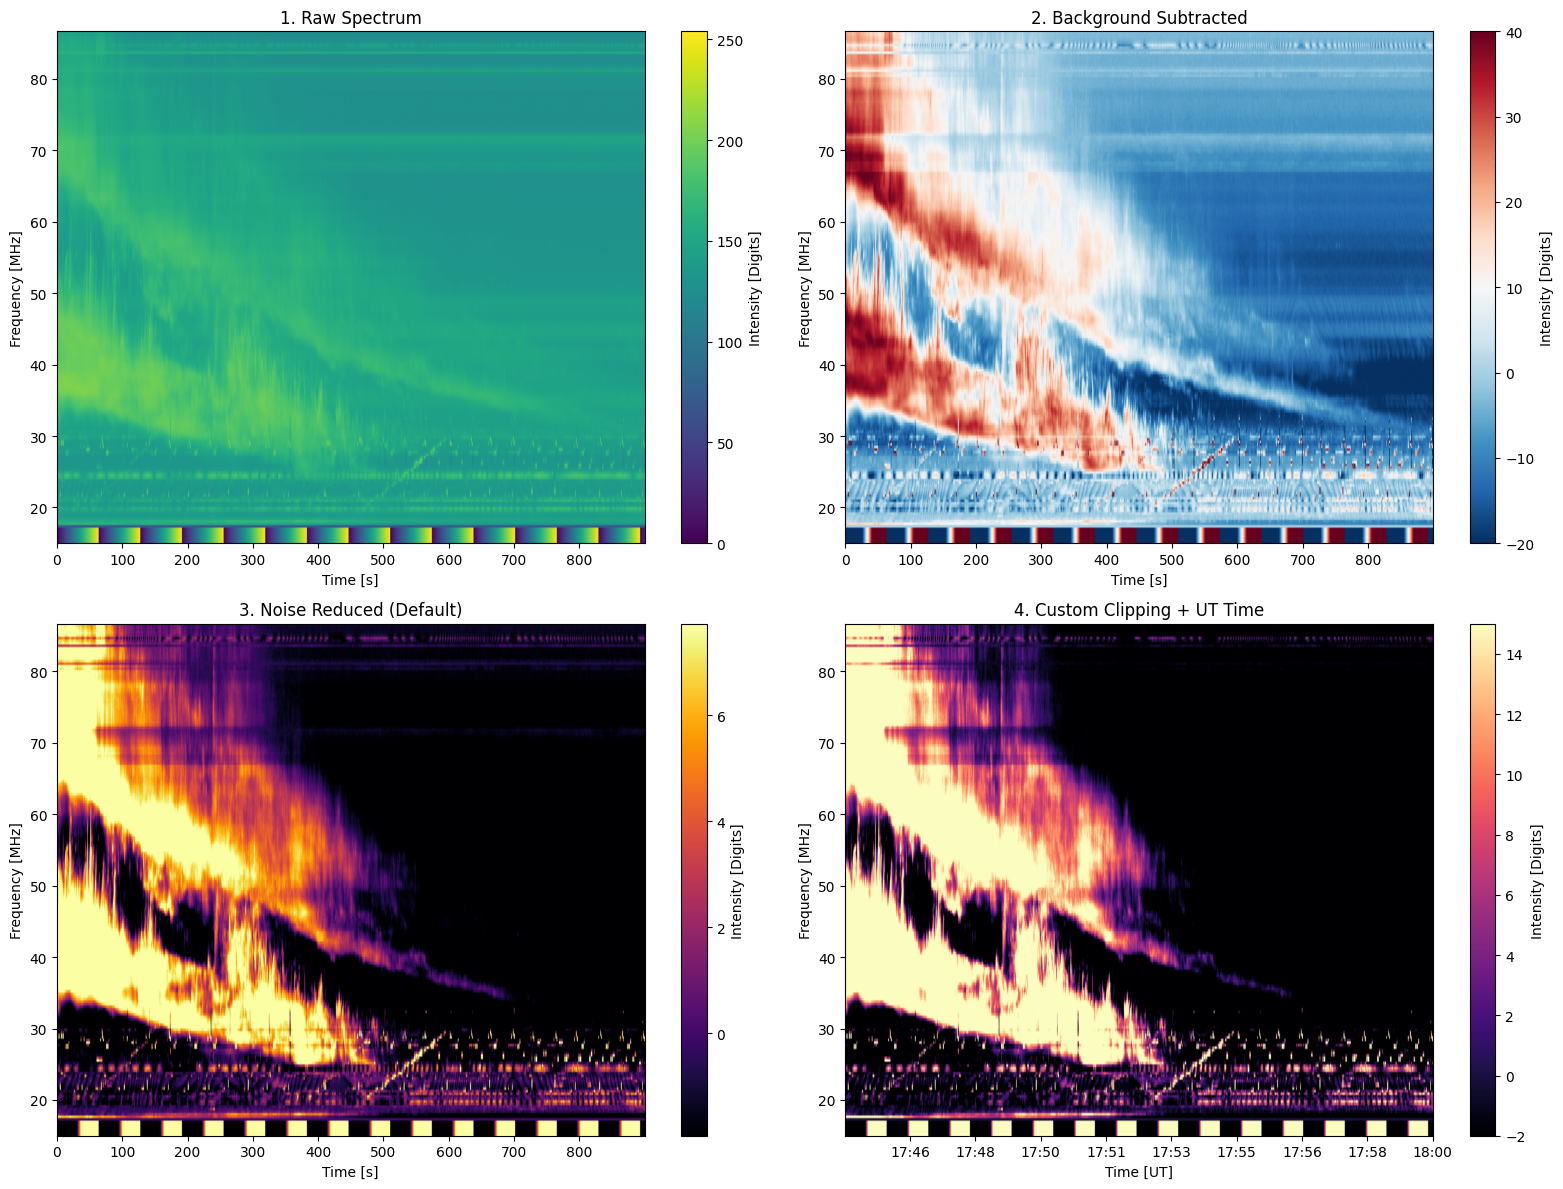


Saved figure to 'plotting_demo.png'


In [39]:
# Load data
ds = ecl.read_fits("/Users/saan/Desktop/ecallistolib/data/Arecibo-Observatory_20220302_174500_62.fit.gz")
print(f"Loaded: {ds.meta.get('station')} observation from {ds.meta.get('date')}")

# Create figure with 4 panels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Raw data
ecl.plot_raw_spectrum(
    ds,
    ax=axes[0, 0],
    title="1. Raw Spectrum",
    cmap="viridis",
)

# 2. Background subtracted (before clipping)
ecl.plot_background_subtracted(
    ds,
    ax=axes[0, 1],
    title="2. Background Subtracted",
    clip_low=-20,
    clip_high=40,
    cmap="RdBu_r",
)

# 3. Noise reduced (default params)
ds_reduced = ecl.noise_reduce_mean_clip(ds, clip_low=-5, clip_high=20)
ecl.plot_dynamic_spectrum(
    ds_reduced,
    ax=axes[1, 0],
    title="3. Noise Reduced (Default)",
    cmap="inferno",
)

# 4. Noise reduced with custom clipping + UT time
ds_custom = ecl.noise_reduce_mean_clip(ds, clip_low=-2, clip_high=15, scale=None)
ecl.plot_dynamic_spectrum(
    ds_custom,
    ax=axes[1, 1],
    title="4. Custom Clipping + UT Time",
    clip_low=-2,
    clip_high=15,
    cmap="magma",
    time_format="ut",
)

plt.tight_layout()
plt.savefig("plotting_demo.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nSaved figure to 'plotting_demo.png'")

## Summary

This notebook demonstrated:

| Feature | Function | Description |
|---------|----------|-------------|
| Raw plotting | `plot_raw_spectrum()` | Visualize unprocessed data |
| Background subtraction | `background_subtract()` | Mean removal without clipping |
| Background plot | `plot_background_subtracted()` | Convenience function |
| Custom clipping | `vmin`, `vmax` params | Control colormap range |
| Figure size | `figsize` param | Set plot dimensions |
| Custom colormap | `cmap` param | Any matplotlib colormap |
| UT time format | `time_format="ut"` | Display time in HH:MM:SS |
| Intensity units | `intensity_units="dB"` | Use dB instead of raw Digits |
| Time conversion | `TimeAxisConverter` | Seconds ↔ UT programmatically |
| Light curve | `plot_light_curve()` | Intensity vs time at specific frequency |
| Extra params | `**imshow_kwargs` | interpolation, alpha, etc. |